# Q2


*   In this question we will Build a bigram HMM tagger.
*   First we split the part-of-speech-tagged corpus into a training set and test set.
*   From the labeled training set, we train the transition and observation probabilities of the HMM tagger directly on the hand-tagged data.
*   Then implement the Viterbi algorithm so we can decode a test sentence.
*   Run the algorithm on the test set. Report its error rate and
compare its performance to the most frequent tag baseline.
*   Build a confusion matrix and investigate the most frequent errors.


In [1]:
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [2]:
import math
import nltk
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [3]:
def collect_probabilities(_samples):
    """
    Collects various probabilities and frequencies required for Hidden Markov Model (HMM) training based on given samples.

    Args:
    _samples (list): A list of tuples containing (word, tag) pairs representing training data.

    Returns:
    tuple: A tuple containing four dictionaries:
           - tag_freq: A dictionary storing the frequency of each tag type.
           - word_per_tag_freq: A nested dictionary storing the frequency of each word under each tag.
           - bigram: A nested dictionary representing the bigram probabilities between tag types.
           - pi: A dictionary storing the initial probability distributions for tag types.

    Comments:
    - tag_freq: Stores the frequency of each tag type observed in the training data.
    - word_per_tag_freq: Stores the frequency of each word observed under each tag in the training data.
      - Each word under a specific tag is initialized with a count of 2 to provide initial smoothing.
    - bigram: Represents the transition probabilities between tag types based on bigram counts.
    - pi: Stores the initial probability distributions for tag types based on the second tag in each sample.
    """
    tag_freq = {}
    word_per_tag_freq = {}
    bigram = {}
    pi = {}
    samples_len = len(_samples)

    # Iterate through samples to collect tag frequencies, word frequencies under each tag, and initial probabilities
    for i in range(samples_len):
        sample = _samples[i]
        has_next = i + 1 < samples_len

        # Collect data for initial probabilities (pi)
        if has_next:
            if _samples[i + 1][1] not in pi:
                pi[_samples[i + 1][1]] = 2
            else:
                pi[_samples[i + 1][1]] += 1

        # Count tag frequencies (tag_freq) and word frequencies under each tag (word_per_tag_freq)
        tag = sample[1]
        word = sample[0]
        if tag not in tag_freq:
            tag_freq[tag] = 1
            word_per_tag_freq[tag] = {word: 1}
        else:
            tag_freq[tag] += 1
            if word not in word_per_tag_freq[tag]:
                word_per_tag_freq[tag][word] = 1
            else:
                word_per_tag_freq[tag][word] += 1

    # Initialize the bigram matrix with default counts
    for tag_0 in tag_freq:
        bigram[tag_0] = {}
        for tag_1 in tag_freq:
            bigram[tag_0][tag_1] = 1

    # Count bigram occurrences
    for i in range(samples_len - 1):
        current_tag = _samples[i][1]
        next_tag = _samples[i + 1][1]
        bigram[current_tag][next_tag] += 1

    # Return collected probabilities and frequencies
    return tag_freq, word_per_tag_freq, bigram, pi

In [4]:
def create_confusion_matrix(predictions, hidden_state, confusion_matrices, is_correct):
    """
    Updates the confusion matrices based on the predictions and hidden states,
    calculates the number of correct predictions, and identifies tags with
    the most false positives and false negatives.

    Args:
    predictions (list): Predicted sequence of tags for the given input data.
    hidden_state (list): Actual sequence of tags for the given input data.
    confusion_matrices (dict): A dictionary containing confusion matrices for each tag.
    is_correct (int): Counter for the number of correct predictions.

    Returns:
    int: Updated count of correct predictions after processing the input data.

    Comments:
    - As the Viterbi algorithm processes each sentence in the test data,
      it compares the predicted tags against the actual tags for each word in the sentence.
        - For each word in the sentence, if the predicted tag matches the actual tag (a true positive),
          the corresponding count in the confusion matrix for that tag is incremented.
        - If the predicted tag does not match the actual tag:
            - If the predicted tag is incorrect (a false positive), the FP count for
              the predicted tag is incremented, and the TN counts for other tags are incremented.
            - If the actual tag is not predicted (a false negative), the FN count for the actual
              tag is incremented, and the TN counts for other tags are incremented.
    - After updating the confusion matrices, the function identifies tags with
      the highest counts of false positives and false negatives.
    """
    # fill in the confusion matrix
    for i in range(len(predictions)):
        if predictions[i] == hidden_state[i]:
            # prediction is correct
            is_correct += 1
            for j in confusion_matrices:
                if predictions[i] == j:
                    confusion_matrices[j]['TP'] += 1
                else:
                    confusion_matrices[j]['TN'] += 1

        else:
            # prediction is incorrect
            for j in confusion_matrices:
                if predictions[i] == j:
                    confusion_matrices[j]['FP'] += 1
                if hidden_state[i] == j:
                    confusion_matrices[j]['FN'] += 1

    # rank
    highest_FP_tag = []
    highest_FP = -1
    highest_FN_tag = []
    highest_FN = -1

    for tag in confusion_matrices:
        if confusion_matrices[tag]['FP'] > highest_FP:
            highest_FP = confusion_matrices[tag]['FP']
            highest_FP_tag = tag

        if confusion_matrices[tag]['FN'] > highest_FN:
            highest_FN = confusion_matrices[tag]['FN']
            highest_FN_tag = tag

    print(f'\nTag with the most false positives is: {highest_FP_tag} with {highest_FP} counts.')
    print(f'Tag with the most false negative is:  {highest_FN_tag} with {highest_FN} counts.')

    return is_correct

In [5]:
def viterbi(_samples, _tag_freq, _word_per_tag_freq, _bigram, _init_dist):
    """
    Performs the Viterbi algorithm for part-of-speech tagging on a given test set of sentences.

    Args:
    _samples (list): A list of tuples containing (word, tag) pairs representing the test data.
    _tag_freq (dict): A dictionary storing the frequency of each tag type observed in the training data.
    _word_per_tag_freq (dict): A nested dictionary storing the frequency of each word observed under each tag in the training data.
    _bigram (dict): A nested dictionary representing the bigram probabilities between tag types.
    _init_dist (dict): A dictionary storing the initial probability distributions for tag types.

    Comments:
    - This function implements the Viterbi algorithm for part-of-speech tagging.
    - It processes each sentence in the test set, using '.' as an indicator that a sentence is over.
    - The function populates a confusion matrix to track the performance of the model.
    - The Viterbi algorithm is used to find the most likely sequence of tags for each sentence.
    - The algorithm iterates through each word in the sentence, calculating the most likely tag sequence based on probabilities and transition probabilities.
    - The model's predictions are compared against the actual tags to evaluate accuracy and populate the confusion matrix.
    - The function prints detailed information about predictions, including the sentence, hidden states, and predicted tags.
    - It also identifies tags with the most false positives and false negatives based on the confusion matrix.
    - Finally, the function prints the overall accuracy of the model on the test set.
    """
    test_size = len(_samples)
    current_index = 0
    is_correct = 0

    # populate the confusion matrix
    confusion_matrices = {}
    for tag in _tag_freq:
        confusion_matrices.update({tag: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}})

    while current_index < test_size:
        # find the boundary of a sentence
        sentence = []
        hidden_state = []
        last_token = ''
        while last_token != '.' and current_index < test_size:
            sentence.append(_samples[current_index][0])  # append the word from the sample
            hidden_state.append(_samples[current_index][1])  # append the tag from the sample
            last_token = _samples[current_index][0]
            current_index += 1

        # initialization step
        path_probability = {}
        backpointer = {}
        for tag in _init_dist:
            path_probability[tag] = []
            backpointer[tag] = [0]

            # initial distribution of this tag
            pi_tag = _init_dist[tag]

            # b_word is the probability of the word being generated by this tag
            if sentence[0] in _word_per_tag_freq[tag]:
                b_word = _word_per_tag_freq[tag][sentence[0]] / _tag_freq[tag]
            else:
                b_word = 2.2250738585072014e-100
            path_probability[tag].append(math.log(pi_tag, 10) + math.log(b_word, 10))

        # recursion step
        T = len(sentence)
        for i in range(1, T):
            for tag in _init_dist:

                if sentence[i] in _word_per_tag_freq[tag]:
                    b_word = _word_per_tag_freq[tag][sentence[i]] / _tag_freq[tag]
                else:
                    b_word = 2.2250738585072014e-100

                # search the maximum value of
                # viterbi[s', t-1] * a(s|s') *b_s(o_t)
                best_trans_prob = -2.2250738585072014e+308
                best_trans_tag = ''
                for prev_tag in _init_dist:
                    if prev_tag in _bigram and tag in _bigram[prev_tag]:
                        transitional_prob = _bigram[prev_tag][tag]
                    else:
                        transitional_prob = 2.2250738585072014e-100

                    prob = path_probability[prev_tag][i - 1] + math.log(transitional_prob, 10) + math.log(b_word, 10)

                    if prob > best_trans_prob:
                        best_trans_prob = prob
                        best_trans_tag = prev_tag

                path_probability[tag].append(best_trans_prob)
                backpointer[tag].append(best_trans_tag)

        # termination step
        best_path_prob = -2.2250738585072014e+308
        best_path_pointer = None
        for tag in _init_dist:
            if path_probability[tag][-1] > best_path_prob:
                best_path_prob = path_probability[tag][-1]
                best_path_pointer = tag

        predictions = [best_path_pointer]

        # make the predictions path
        for i in reversed(range(1, T)):
            predictions.insert(0, backpointer[predictions[0]][i])

        print(f'sentence:       {sentence}')
        print(f'hidden s:       {hidden_state}')
        print(f'predictions:    {predictions}')

        is_correct = create_confusion_matrix(predictions, hidden_state, confusion_matrices, is_correct)

    print(f'\nmodel got {is_correct} samples correct out of {test_size}')
    print(f'accuracy: {is_correct / test_size}')


def create_confusion_matrix(predictions, hidden_state, confusion_matrices, is_correct):
    for predicted_tag, actual_tag in zip(predictions, hidden_state):
        if predicted_tag == actual_tag:
            is_correct += 1
            confusion_matrices[predicted_tag]['TP'] += 1
            for tag in confusion_matrices:
                if tag != predicted_tag:
                    confusion_matrices[tag]['TN'] += 1
        else:
            confusion_matrices[predicted_tag]['FP'] += 1
            confusion_matrices[actual_tag]['FN'] += 1
            for tag in confusion_matrices:
                if tag != predicted_tag and tag != actual_tag:
                    confusion_matrices[tag]['TN'] += 1
    return is_correct

In [6]:
CORPUS = brown.tagged_words(categories='news', tagset='universal')
CORPUS_SIZE = len(brown.tagged_words(categories='news'))

CUT_OFF = math.floor(CORPUS_SIZE * 0.75)

# section off training and testing lists from corpus
training_list = CORPUS[:CUT_OFF]
testing_list = CORPUS[CUT_OFF:]

tag_frequency, word_per_tag_frequency, tag_bigram, init_dist = collect_probabilities(training_list)
viterbi(testing_list, tag_frequency, word_per_tag_frequency, tag_bigram, init_dist)


sentence:       ['these', 'could', 'not', 'be', 'talked', 'away', 'at', 'a', 'heads', 'of', 'government', 'meeting', '.']
hidden s:       ['DET', 'VERB', 'ADV', 'VERB', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
predictions:    ['DET', 'VERB', 'ADV', 'VERB', 'VERB', 'ADV', 'ADP', 'DET', 'VERB', 'ADP', 'NOUN', 'NOUN', '.']
sentence:       ['He', 'wanted', 'to', 'buy', 'time', 'to', 'strengthen', 'the', 'U.', 'S.', 'and', 'its', 'allies', 'and', 'to', 'define', 'and', 'begin', 'to', 'implement', 'his', 'foreign', 'policy', '.']
hidden s:       ['PRON', 'VERB', 'PRT', 'VERB', 'NOUN', 'PRT', 'VERB', 'DET', 'NOUN', 'NOUN', 'CONJ', 'DET', 'NOUN', 'CONJ', 'PRT', 'VERB', 'CONJ', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', '.']
predictions:    ['PRON', 'VERB', 'PRT', 'VERB', 'NOUN', 'PRT', 'VERB', 'DET', 'NOUN', 'NOUN', 'CONJ', 'DET', 'NOUN', 'CONJ', 'ADP', 'NOUN', 'CONJ', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', '.']
sentence:       ['Last', 'Friday', 'the', 'White',

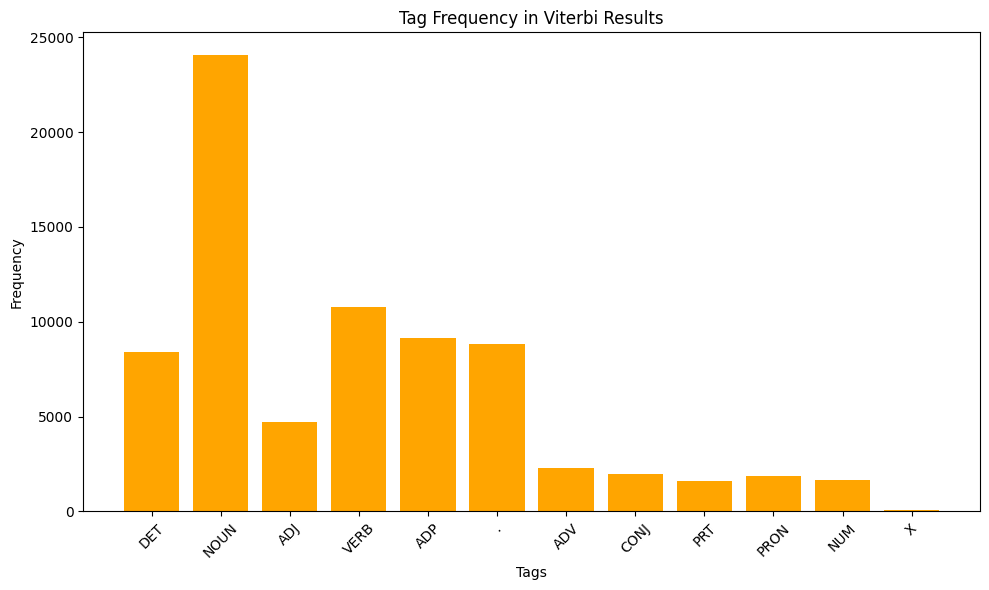

In [8]:
import matplotlib.pyplot as plt

tags = list(tag_frequency.keys())
tag_counts = list(tag_frequency.values())

plt.figure(figsize=(10, 6))
plt.bar(tags, tag_counts, color='orange')
plt.title('Tag Frequency in Viterbi Results')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
